In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import R2_Bayes as r2

In [3]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [4]:
#DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['mean_farmsize']= DF['ACRES OPERATED']/DF['NUMBER OF OPERATIONS']
DF['tavg_sd']= DF['tavg_coeff']* DF['tavg_mean']
DF['pcp_sd']= DF['pcp_mm_coeff']* DF['pcp_mm_mean']
DF['edd_sd']= DF['edd_coeff']* DF['edd_mean']
DF['pcpdays_sd']= DF['pcpdays_coeff']* DF['pcpdays_mean']

In [5]:
DF= DF[DF['state_name']!= 'ALASKA']
DF= DF[DF['state_name']!= 'HAWAII']

In [6]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

In [7]:
DF.columns

Index(['year', 'state_name', 'state_fips_code', 'domaincat_desc',
       'ACRES OPERATED', 'NUMBER OF OPERATIONS', 'farmcat', 'lower_bound',
       'upper_bound', '(EXCL CRP) - ACRES', 'DRAINED BY TILE - ACRES',
       '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS', 'CROP INSURANCE - ACRES',
       'CROP INSURANCE - NUMBER OF OPERATIONS',
       'IRRIGATED - NUMBER OF OPERATIONS_x', 'RENTED FROM OTHERS_x',
       'RENTED FROM OTHERS_y', 'OWNED_x', 'OWNED_y', 'IRRIGATED - ACRES',
       'IRRIGATED - NUMBER OF OPERATIONS_y',
       'NET INCOME, MEASURED IN $ / OPERATION', 'FEDERAL - RECEIPTS',
       'FEDERAL - OPERATIONS WITH RECEIPTS', 'tot_income', 'income_ope',
       'STATE & LOCAL - RECEIPTS', 'STATE & LOCAL - OPERATIONS WITH RECEIPTS',
       'HIRED - EXPENSE', 'HIRED - OPERATIONS WITH EXPENSE',
       'CONTRACT - EXPENSE', 'CONTRACT - OPERATIONS WITH EXPENSE',
       'EXPENSE, MEASURED IN $', 'OPERATIONS WITH EXPENSE',
       'MACHINERY TOTAL

### Prepare data for Bayesian Models

In [8]:
DF.dropna(axis=0, how='any',subset=['cover_crops','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'tavg_mean', 'pcp_mm_mean','edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd','edd_sd','pcpdays_sd',
        'tavg_z', 'pcp_mm_z', 'edd_z','pcpdays_z'], inplace=True)

In [9]:
DF

,year,state_name,state_fips_code,domaincat_desc,ACRES OPERATED,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,(EXCL CRP) - ACRES,...,veggies_shareope,fruit_shareope,cattle_shareope,year_2017,year_2022,mean_farmsize,tavg_sd,pcp_sd,edd_sd,pcpdays_sd
0,2012,ALABAMA,1,AREA OPERATED: (1.0 TO 9.9 ACRES),14379.0,2919,1-10,1,9.0,139.0,...,0.079822,0.073998,0.220281,0,0,4.926002,0.683609,290.936231,15.185549,4.684287
1,2012,ALABAMA,1,AREA OPERATED: (10.0 TO 49.9 ACRES),362197.0,13267,10-50,10,49.0,2651.0,...,0.035803,0.036858,0.373785,0,0,27.300595,0.683609,290.936231,15.185549,4.684287
2,2012,ALABAMA,1,AREA OPERATED: (50.0 TO 69.9 ACRES),246346.0,4235,50-70,50,69.0,1984.0,...,0.016765,0.023849,0.452893,0,0,58.169067,0.683609,290.936231,15.185549,4.684287
3,2012,ALABAMA,1,AREA OPERATED: (70.0 TO 99.9 ACRES),377435.0,4605,70-100,70,99.0,2921.0,...,0.018458,0.022150,0.488599,0,0,81.961998,0.683609,290.936231,15.185549,4.684287
4,2012,ALABAMA,1,AREA OPERATED: (100 TO 139 ACRES),500043.0,4342,100-140,100,139.0,3569.0,...,0.019116,0.024413,0.463611,0,0,115.164210,0.683609,290.936231,15.185549,4.684287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,2022,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),55708.0,234,220-260,220,259.0,641.0,...,0.000000,0.000000,0.363248,0,1,238.068376,0.510042,85.053539,17.611999,0.449519
1724,2022,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),320538.0,887,260-500,260,499.0,2525.0,...,0.001127,0.000000,0.394589,0,1,361.373168,0.510042,85.053539,17.611999,0.449519
1725,2022,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),619090.0,882,500-1K,500,999.0,5269.0,...,0.000000,0.001134,0.460317,0,1,701.916100,0.510042,85.053539,17.611999,0.449519
1726,2022,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1102112.0,798,1K-2K,1000,1999.0,6328.0,...,0.000000,0.000000,0.527569,0,1,1381.092732,0.510042,85.053539,17.611999,0.449519


In [9]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['state_fips_code','farmcat','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['state_fips_code','farmcat'])['cons'].transform(sum)

In [10]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
fe_vars= ['cover_crops','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'tavg_mean', 'pcp_mm_mean','edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd','edd_sd','pcpdays_sd',
        'tavg_z', 'pcp_mm_z', 'edd_z','pcpdays_z']
DF1= DF[['times','state_fips_code','year','farmcat','farm_class','class','year_2017', 'year_2022']+fe_vars]
DF1= DF1[DF1['times']>1] # select farm groups with more that 2 years of data

#Standardize variables within farm size and state groups
for x in fe_vars:    
    DF1[x+'_fe']= (DF1[x] - DF1.groupby(['state_fips_code','farmcat'])[x].transform('mean'))/(DF1.groupby(['state_fips_code','farmcat'])[x].transform('std'))
    


# Pooled model

In [11]:

# Priors
st_sd=1
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= st_sd)
}
## Pooled model
modelp = bmb.Model("cover_crops_fe ~ 0+ (mean_farmsize_fe)\
                    +(insured_farms_fe)+\
       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+\
       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+\
       (veggies_shareope_fe)+(cattle_shareope_fe)+\
       (edd_mean_fe)+(pcpdays_mean_fe)+\
       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+\
       (year_2017)+(year_2022)", 
                     DF1, priors= priorsp, dropna=True)
modelp #(tavg_z_fe) + (pcp_mm_z_fe)+ (edd_z_fe) + (pcpdays_z_fe)

Automatically removing 53/1588 rows from the dataset.


Formula: cover_crops_fe ~ 0+ (mean_farmsize_fe)                    +(insured_farms_fe)+       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+       (veggies_shareope_fe)+(cattle_shareope_fe)+       (edd_mean_fe)+(pcpdays_mean_fe)+       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+       (year_2017)+(year_2022)
Family name: Gaussian
Link: identity
Observations: 1535
Priors:
  Common-level effects
    mean_farmsize_fe ~ Laplace(mu: 0, b: 1)
    insured_farms_fe ~ Laplace(mu: 0, b: 1)
    fed_income_fe ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe ~ Laplace(mu: 0, b: 1)
    labor_expense_fe ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe ~ Laplace(mu: 0, b: 1)
    rented_land_fe ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe ~ Laplace(mu: 0, b: 1)
    veggies_shareope_fe ~ Laplace(mu: 0, b: 1)
    cattle_shareope_fe ~ Laplace(mu: 0, b: 1)
    edd_mean_fe ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_fe ~ Laplace(mu: 

In [12]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_fe_sigma, year_2022, year_2017, pcp_mm_z_fe, tavg_z_fe, pcp_sd_fe, tavg_sd_fe, pcpdays_mean_fe, edd_mean_fe, cattle_shareope_fe, veggies_shareope_fe, grains_shareope_fe, rented_land_fe, machinery_asset_fe, labor_expense_fe, statepay_ope_fe, fed_income_fe, insured_farms_fe, mean_farmsize_fe]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


In [13]:
az.summary(tracep)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_farmsize_fe,0.018,0.020,-0.016,0.058,0.000,0.000,5177.0,2952.0,1.00
insured_farms_fe,0.149,0.024,0.105,0.198,0.000,0.000,4932.0,3041.0,1.00
fed_income_fe,0.017,0.024,-0.025,0.065,0.000,0.000,4810.0,3148.0,1.00
statepay_ope_fe,0.083,0.020,0.045,0.121,0.000,0.000,6422.0,3348.0,1.00
labor_expense_fe,0.001,0.023,-0.043,0.044,0.000,0.000,4612.0,3041.0,1.00
machinery_asset_fe,-0.019,0.022,-0.061,0.021,0.000,0.000,5061.0,3298.0,1.00
rented_land_fe,-0.012,0.025,-0.056,0.036,0.000,0.000,3741.0,2942.0,1.00
grains_shareope_fe,-0.003,0.021,-0.045,0.036,0.000,0.000,5967.0,2855.0,1.00
veggies_shareope_fe,0.027,0.020,-0.011,0.063,0.000,0.000,7230.0,3062.0,1.00
cattle_shareope_fe,-0.079,0.024,-0.125,-0.033,0.000,0.000,4663.0,3027.0,1.00


In [78]:

DF1['cons']=1

selvars=['cons', 'mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']


varspost= ['Intercept','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe',
        'year_2017','year_2022']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [79]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean,'identity', tracep, 'cover_crops_fe',selvars,varspost, False, x,4,1000,x)

In [80]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.43392684692593286
Lower CI: 0.40658954869483616
Upper CI: 0.46002403213824944


In [67]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracep,var_names=varspost[12:], hdi_prob = 0.99).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.5734 -0.2563
    mean_farmsize_fe     (hdi) float64 -0.04088 0.05514
    insured_farms_fe     (hdi) float64 0.03264 0.1658
    fed_income_fe        (hdi) float64 -0.04462 0.07597
    statepay_ope_fe      (hdi) float64 0.01885 0.1231
    labor_expense_fe     (hdi) float64 -0.09738 0.02278
    machinery_asset_fe   (hdi) float64 -0.05843 0.05124
    rented_land_fe       (hdi) float64 -0.03267 0.09684
    grains_shareope_fe   (hdi) float64 -0.04305 0.06271
    veggies_shareope_fe  (hdi) float64 -0.04383 0.05989
    cattle_shareope_fe   (hdi) float64 -0.1433 -0.02459
    edd_mean_fe          (hdi) float64 -0.1298 0.1121)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.1176 0.04652
    t

In [68]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracep,var_names=varspost[12:24], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.5253 -0.3254
    mean_farmsize_fe     (hdi) float64 -0.0284 0.03669
    insured_farms_fe     (hdi) float64 0.05846 0.1406
    fed_income_fe        (hdi) float64 -0.02387 0.05409
    statepay_ope_fe      (hdi) float64 0.03738 0.105
    labor_expense_fe     (hdi) float64 -0.07187 0.00637
    machinery_asset_fe   (hdi) float64 -0.03756 0.03298
    rented_land_fe       (hdi) float64 -0.003648 0.07807
    grains_shareope_fe   (hdi) float64 -0.02034 0.0473
    veggies_shareope_fe  (hdi) float64 -0.02067 0.04422
    cattle_shareope_fe   (hdi) float64 -0.1176 -0.04317
    edd_mean_fe          (hdi) float64 -0.08463 0.07047)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.0876 0.01918
    t

# Hierarchical model 

In [59]:
st_sd= 1 #bmb.Prior("HalfCauchy", beta= 1)


priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'tavg_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcp_mm_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
}


In [60]:
model = bmb.Model("cover_crops_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+\
       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+\
       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+\
       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+\
       (edd_mean_fe|class)+(pcpdays_mean_fe|class) +\
       (tavg_sd_fe|class) + (pcp_sd_fe|class) + (tavg_z_fe|class) + (pcp_mm_z_fe|class)+\
       (year_2017|class)+ (year_2022|class)", 
        DF1, priors= priorsc, dropna=True)
#
model

Formula: cover_crops_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+       (edd_mean_fe|class)+(pcpdays_mean_fe|class) +       (tavg_sd_fe|class) + (pcp_sd_fe|class) + (tavg_z_fe|class) + (pcp_mm_z_fe|class)+       (year_2017|class)+ (year_2022|class)
Family name: Gaussian
Link: identity
Observations: 1535
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 1)
    mean_farmsize_fe|class ~ Laplace(mu: 0, b: 1)
    insured_farms_fe|class ~ Laplace(mu: 0, b: 1)
    fed_income_fe|class ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe|class ~ Laplace(mu: 0, b: 1)
    labor_expense_fe|class ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe|class ~ Laplace(mu: 0, b: 1)
    rented_land_fe|class ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe|class ~ 

In [61]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_fe_sigma, year_2022|class, year_2017|class, pcp_mm_z_fe|class, tavg_z_fe|class, pcp_sd_fe|class, tavg_sd_fe|class, pcpdays_mean_fe|class, edd_mean_fe|class, cattle_shareope_fe|class, veggies_shareope_fe|class, grains_shareope_fe|class, rented_land_fe|class, machinery_asset_fe|class, labor_expense_fe|class, statepay_ope_fe|class, fed_income_fe|class, insured_farms_fe|class, mean_farmsize_fe|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 399 seconds.


In [62]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],-0.568,0.105,-0.764,-0.369,0.003,0.002,1218.0,2050.0,1.01,1|class[0],0
mean_farmsize_fe|class[0],0.020,0.032,-0.035,0.084,0.000,0.000,4164.0,2869.0,1.00,mean_farmsize_fe|class[0],0
insured_farms_fe|class[0],0.103,0.046,0.017,0.189,0.001,0.001,3437.0,2644.0,1.00,insured_farms_fe|class[0],0
fed_income_fe|class[0],-0.005,0.039,-0.078,0.069,0.001,0.001,4282.0,2907.0,1.00,fed_income_fe|class[0],0
statepay_ope_fe|class[0],0.031,0.035,-0.035,0.098,0.000,0.000,5143.0,2904.0,1.00,statepay_ope_fe|class[0],0
labor_expense_fe|class[0],0.021,0.036,-0.047,0.086,0.001,0.000,4940.0,2901.0,1.00,labor_expense_fe|class[0],0
machinery_asset_fe|class[0],-0.061,0.037,-0.133,0.004,0.001,0.000,4230.0,2752.0,1.00,machinery_asset_fe|class[0],0
rented_land_fe|class[0],0.060,0.048,-0.027,0.153,0.001,0.001,3424.0,3167.0,1.00,rented_land_fe|class[0],0
grains_shareope_fe|class[0],-0.007,0.034,-0.070,0.060,0.000,0.001,5356.0,2923.0,1.00,grains_shareope_fe|class[0],0
veggies_shareope_fe|class[0],0.025,0.034,-0.039,0.091,0.000,0.000,5285.0,3077.0,1.00,veggies_shareope_fe|class[0],0


In [63]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],-0.358,0.104,-0.555,-0.161,0.003,0.002,1518.0,2021.0,1.0,1|class[1],1
mean_farmsize_fe|class[1],0.008,0.034,-0.056,0.071,0.000,0.001,6017.0,3246.0,1.0,mean_farmsize_fe|class[1],1
insured_farms_fe|class[1],0.125,0.043,0.042,0.204,0.001,0.000,4399.0,3196.0,1.0,insured_farms_fe|class[1],1
fed_income_fe|class[1],0.004,0.041,-0.072,0.081,0.001,0.001,4506.0,3215.0,1.0,fed_income_fe|class[1],1
statepay_ope_fe|class[1],0.030,0.036,-0.041,0.093,0.001,0.000,4560.0,3244.0,1.0,statepay_ope_fe|class[1],1
labor_expense_fe|class[1],-0.093,0.041,-0.168,-0.018,0.001,0.000,4506.0,3193.0,1.0,labor_expense_fe|class[1],1
machinery_asset_fe|class[1],0.022,0.038,-0.047,0.095,0.001,0.001,4543.0,3103.0,1.0,machinery_asset_fe|class[1],1
rented_land_fe|class[1],-0.064,0.045,-0.151,0.017,0.001,0.001,3992.0,3109.0,1.0,rented_land_fe|class[1],1
grains_shareope_fe|class[1],0.090,0.040,0.015,0.163,0.001,0.000,3913.0,2911.0,1.0,grains_shareope_fe|class[1],1
veggies_shareope_fe|class[1],0.016,0.033,-0.045,0.079,0.001,0.000,4377.0,2922.0,1.0,veggies_shareope_fe|class[1],1


In [64]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-0.337,0.102,-0.526,-0.142,0.003,0.002,1358.0,2170.0,1.0,1|class[2],2
mean_farmsize_fe|class[2],0.007,0.035,-0.060,0.074,0.001,0.001,4833.0,3093.0,1.0,mean_farmsize_fe|class[2],2
insured_farms_fe|class[2],0.060,0.041,-0.022,0.134,0.001,0.000,4091.0,3219.0,1.0,insured_farms_fe|class[2],2
fed_income_fe|class[2],-0.024,0.041,-0.101,0.053,0.001,0.001,3086.0,2919.0,1.0,fed_income_fe|class[2],2
statepay_ope_fe|class[2],0.123,0.037,0.052,0.193,0.001,0.000,5011.0,2852.0,1.0,statepay_ope_fe|class[2],2
labor_expense_fe|class[2],-0.073,0.049,-0.161,0.022,0.001,0.001,3442.0,2661.0,1.0,labor_expense_fe|class[2],2
machinery_asset_fe|class[2],0.035,0.043,-0.040,0.119,0.001,0.001,3400.0,3152.0,1.0,machinery_asset_fe|class[2],2
rented_land_fe|class[2],0.079,0.039,0.006,0.153,0.001,0.000,4649.0,3122.0,1.0,rented_land_fe|class[2],2
grains_shareope_fe|class[2],-0.068,0.039,-0.139,0.005,0.001,0.000,5511.0,3507.0,1.0,grains_shareope_fe|class[2],2
veggies_shareope_fe|class[2],0.006,0.036,-0.063,0.072,0.001,0.001,4542.0,3082.0,1.0,veggies_shareope_fe|class[2],2


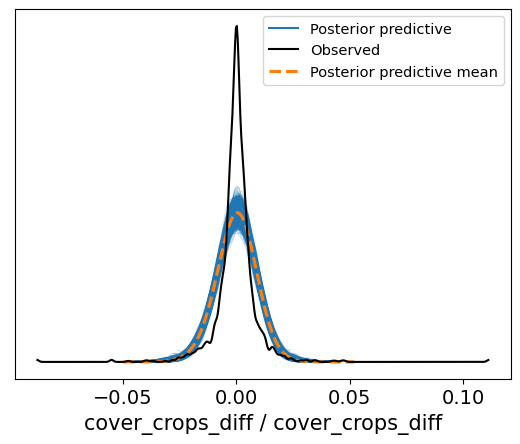

In [110]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [30]:
az.loo(trace)

Computed from 4000 posterior samples and 1588 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  5652.21   133.17
p_loo      116.01        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1579   99.4%
 (0.5, 0.7]   (ok)          4    0.3%
   (0.7, 1]   (bad)         3    0.2%
   (1, Inf)   (very bad)    2    0.1%

## R2 

In [69]:

DF1['cons']=1
selvars=['cons','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']


varspost= ['1|class','mean_farmsize_fe|class',
        'insured_farms_fe|class','fed_income_fe|class', 'statepay_ope_fe|class', 
        'labor_expense_fe|class','machinery_asset_fe|class', 'rented_land_fe|class',
        'grains_shareope_fe|class', 'veggies_shareope_fe|class','cattle_shareope_fe|class',
        'edd_mean_fe|class','pcpdays_mean_fe|class',
        'tavg_sd_fe|class', 'pcp_sd_fe|class','tavg_z_fe|class', 'pcp_mm_z_fe|class',
           'year_2017|class','year_2022|class']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [43]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean,'identity', trace, 'cover_crops_fe',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.429265763850839
Lower CI: 0.4006725418137542
Upper CI: 0.45697606035188704


In [75]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='0'))
print(az.hdi(trace,var_names=varspost[12:24], hdi_prob = 0.90).sel(class_coord_group_factor='0'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '0'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.738 -0.3937
    mean_farmsize_fe|class     (hdi) float64 -0.02927 0.07652
    insured_farms_fe|class     (hdi) float64 0.02511 0.1767
    fed_income_fe|class        (hdi) float64 -0.0676 0.06263
    statepay_ope_fe|class      (hdi) float64 -0.03098 0.08461
    labor_expense_fe|class     (hdi) float64 -0.03696 0.07881
    machinery_asset_fe|class   (hdi) float64 -0.1192 0.0009189
    rented_land_fe|class       (hdi) float64 -0.01532 0.1425
    grains_shareope_fe|class   (hdi) float64 -0.06264 0.05039
    veggies_shareope_fe|class  (hdi) float64 -0.02956 0.08399
    cattle_shareope_fe|class   (hdi) float64 -0.2214 -0.08278
    edd_mean_fe|class          (hdi) float64 -0.2859 -0.007055
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    clas

In [76]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='1'))
print(az.hdi(trace,var_names=varspost[12:24], hdi_prob = 0.90).sel(class_coord_group_factor='1'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '1'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.537 -0.1936
    mean_farmsize_fe|class     (hdi) float64 -0.048 0.06306
    insured_farms_fe|class     (hdi) float64 0.05474 0.1965
    fed_income_fe|class        (hdi) float64 -0.0626 0.07169
    statepay_ope_fe|class      (hdi) float64 -0.02629 0.09037
    labor_expense_fe|class     (hdi) float64 -0.1542 -0.02087
    machinery_asset_fe|class   (hdi) float64 -0.03755 0.08672
    rented_land_fe|class       (hdi) float64 -0.1416 0.006289
    grains_shareope_fe|class   (hdi) float64 0.02798 0.1556
    veggies_shareope_fe|class  (hdi) float64 -0.03445 0.0747
    cattle_shareope_fe|class   (hdi) float64 -0.09172 0.04307
    edd_mean_fe|class          (hdi) float64 -0.1258 0.1227
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_

In [77]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='2'))
print(az.hdi(trace,var_names=varspost[12:25], hdi_prob = 0.90).sel(class_coord_group_factor='2'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '2'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.5006 -0.1656
    mean_farmsize_fe|class     (hdi) float64 -0.04806 0.06798
    insured_farms_fe|class     (hdi) float64 -0.00757 0.1283
    fed_income_fe|class        (hdi) float64 -0.0888 0.04466
    statepay_ope_fe|class      (hdi) float64 0.06341 0.1859
    labor_expense_fe|class     (hdi) float64 -0.1537 0.006631
    machinery_asset_fe|class   (hdi) float64 -0.03112 0.1075
    rented_land_fe|class       (hdi) float64 0.01353 0.1403
    grains_shareope_fe|class   (hdi) float64 -0.1282 -0.002924
    veggies_shareope_fe|class  (hdi) float64 -0.05158 0.0664
    cattle_shareope_fe|class   (hdi) float64 -0.1206 0.008032
    edd_mean_fe|class          (hdi) float64 0.002933 0.2823
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coo

### Model comparison

In [73]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,-1434.016409,59.083535,0.000000,0.59832,30.984133,0.000000,False,log
pooled,1,-1441.727076,20.456245,7.710668,0.40168,30.478233,9.524076,False,log


In [74]:
print('Lower Bound: ', 7.710668-9.524076*2.92)
print('Upper Bound: ', 7.710668+9.524076*2.92)


Lower Bound:  -20.099633920000002
Upper Bound:  35.52096992
